# GSM-VE: Visco-elastic model

In [1]:
%matplotlib widget
import matplotlib.pylab as plt
import sympy as sp
import numpy as np
from IPython.display import display, Math, Markdown
from bmcs_matmod.api import (
    GSMModel, GSM1D_VE, TimeFnMonotonicAscending
)

gsm = GSMModel(GSM1D_VE)

display(Markdown(GSM1D_VE.latex_potentials()))

## class GSM1D_VE
### Helmholtz free energy
$$F = \frac{E \left(\varepsilon - \varepsilon^\mathrm{v}\right)^{2}}{2}$$
$$\left\{ \sigma : - E \left(- \varepsilon + \varepsilon^\mathrm{v}\right)\right\}$$
#### Mechanical dissipation
$$\gamma_{\mathrm{mech}} = \sigma \dot{\varepsilon^\mathrm{v}}$$
#### Lagrangian
$$\mathcal{L} = - \sigma \dot{\varepsilon^\mathrm{v}} - \dot{\lambda}_{0} \left(\eta_\mathrm{ve} \dot{\varepsilon^\mathrm{v}} - \sigma\right)$$
#### Residuum
$$\frac{\partial \mathcal{L}}{\partial \mathcal{S}} = \left[\begin{matrix}\dot{\lambda}_{0} - \dot{\varepsilon^\mathrm{v}}\\- \eta_\mathrm{ve} \dot{\varepsilon^\mathrm{v}} + \sigma\end{matrix}\right] = 0$$
### Legendre transform
#### Strain substitutions in dissipative terms
$$\left\{ \varepsilon : \varepsilon^\mathrm{v} + \frac{\sigma}{E}\right\}$$
$$\left\{ \dot{\varepsilon} : \dot{\varepsilon^\mathrm{v}} + \frac{\dot{\sigma}}{E}\right\}$$
### Gibbs free energy
$$G = \sigma \varepsilon- \left[\frac{E \left(\varepsilon - \varepsilon^\mathrm{v}\right)^{2}}{2}\right] $$
#### Gibbs free energy after strain substitutions
$$G = \sigma \varepsilon^\mathrm{v} + \frac{\sigma^{2}}{2 E}$$
$$\left\{ \sigma : \sigma\right\}$$
#### Mechanical dissipation
$$\gamma_{\mathrm{mech}} = \sigma \dot{\varepsilon^\mathrm{v}}$$
#### Lagrangian
$$\mathcal{L} = - \sigma \dot{\varepsilon^\mathrm{v}} - \dot{\lambda}_{0} \left(\eta_\mathrm{ve} \dot{\varepsilon^\mathrm{v}} - \sigma\right)$$
#### Residuum
$$\frac{\partial \mathcal{L}}{\partial \mathcal{S}} = \left[\begin{matrix}\dot{\lambda}_{0} - \dot{\varepsilon^\mathrm{v}}\\- \eta_\mathrm{ve} \dot{\varepsilon^\mathrm{v}} + \sigma\end{matrix}\right] = 0$$

## Linear strain loading

In [2]:
E_val = 30e+3  # Young's modulus in MPa
eta_val = 30e+3  # Viscosity modulus in Pa / s
mparams = dict(E=E_val, eta_ve=eta_val)
gsm.set_params(**mparams)

In [3]:
f_time = 2  # Final time in seconds
eps_max = 0.01  # Maximum strain
tf = TimeFnMonotonicAscending(rate=eps_max/f_time)
t_t = np.linspace(0, f_time, 100)
eps_n_t = tf(t_t)

In [4]:
rd_ec = gsm.get_F_response(eps_n_t, t_t)
t_t_ec = rd_ec.t_t
eps_t_ec = rd_ec.eps_t[:, 0]
sig_t_ec = rd_ec.sig_t[:, 0, 0]
# use the stress history to reproduce the response using stress control
rd_sc = gsm.get_G_response(sig_t_ec, t_t)
t_t_sc = rd_sc.t_t
iter_t = rd_sc.iter_t[:, 0]
eps_t_sc = rd_sc.eps_t[:, 0, 0]
sig_t_sc = rd_sc.sig_t[:, 0]
eps_t_ec.shape, sig_t_ec.shape, eps_t_sc.shape, sig_t_sc.shape

In [5]:
rd_ec.Eps_t.keys()

dict_keys(['eps_v_a'])

In [6]:
eps_ve_t_ec = rd_ec.Eps_t.eps_v_a[:, 0, 0]
sig_ve_t_ec = rd_ec.Sig_t.sig_v_a[:, 0, 0]
eps_ve_t_sc = rd_sc.Eps_t.eps_v_a[:, 0, 0]
sig_ve_t_sc = rd_sc.Sig_t.sig_v_a[:, 0, 0]
sig_ve_t_ec.shape, eps_ve_t_ec.shape, sig_ve_t_sc.shape, eps_ve_t_sc.shape

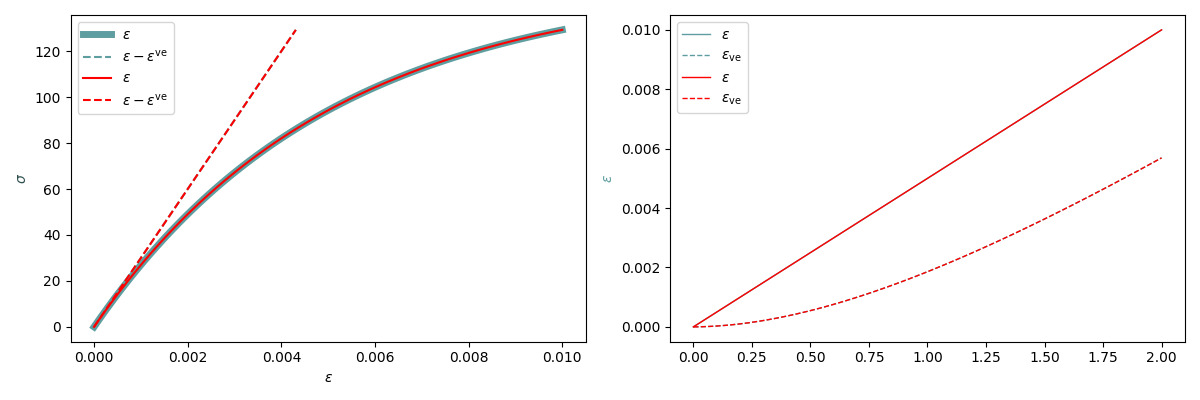

In [7]:
fig, (ax_sig, ax_eps) = plt.subplots(1, 2, figsize=(12, 4))

ax_sig.plot(eps_t_ec, sig_t_ec, color='cadetblue', lw=5, label=r'$\varepsilon$')
ax_sig.plot(eps_t_ec - eps_ve_t_ec, sig_t_ec, ls='dashed', color='cadetblue', label=r'$\varepsilon-\varepsilon^\mathrm{ve}$')

ax_sig.plot(eps_t_sc, sig_t_sc, color='red', label=r'$\varepsilon$')
ax_sig.plot(eps_t_sc - eps_ve_t_sc, sig_t_sc, ls='dashed', color='red', label=r'$\varepsilon-\varepsilon^\mathrm{ve}$')

ax_sig.set_ylabel(r'$\sigma$', color='darkslategray')
ax_sig.set_xlabel(r'$\varepsilon$')
ax_sig.legend()

ax_eps.plot(t_t_ec, eps_t_ec, label=r'$\varepsilon$', color='cadetblue', lw=1)
ax_eps.plot(t_t_ec, eps_ve_t_ec, label=r'$\varepsilon_\mathrm{ve}$', color='cadetblue', ls='dashed', lw=1)

ax_eps.plot(t_t_sc, eps_t_sc, label=r'$\varepsilon$', color='red', lw=1)
ax_eps.plot(t_t_sc, eps_ve_t_sc, label=r'$\varepsilon_\mathrm{ve}$', color='red', ls='dashed', lw=1)
ax_eps.legend()
ax_eps.set_ylabel(r'$\varepsilon$', color='cadetblue')

plt.tight_layout()
plt.show()

## Step-wise strain loading

In [8]:
t_, sig_max_, t_1_, t_2_, t_3_ = sp.symbols('t sig_max t_1 t_2 t_3', real=True, positive=True)
eps_t_ = sp.Piecewise(
    (sig_max_ / t_1_ * t_, t_ < t_1_),
    (sig_max_, t_ < t_2_),
    (sig_max_ - sig_max_/(t_3_-t_2_)*(t_ - t_2_), t_ < t_3_),
    (0, True)
)
get_eps_t = sp.lambdify((t_, sig_max_, t_1_, t_2_, t_3_), eps_t_, 'numpy')
eps_max = 2
n_t_ec = 100
t_t = np.linspace(0, f_time, n_t_ec)
eps_n_t = get_eps_t(t_t, eps_max, 0.25*f_time, 0.5*f_time, 0.75*f_time)


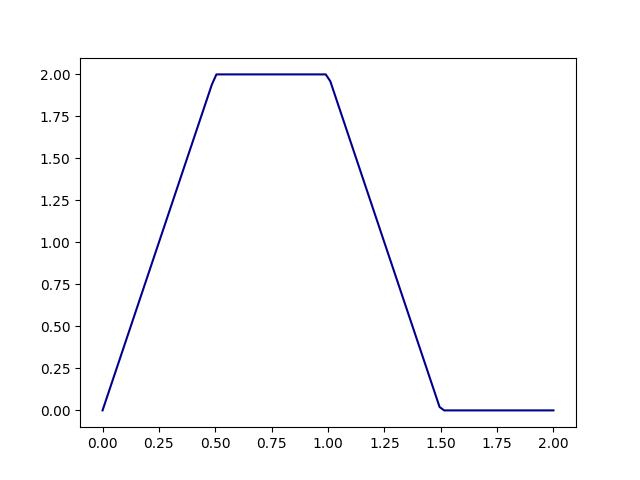

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(t_t, eps_n_t, color='darkblue')

Text(0.5, 1.0, 'Cyclic Strain Loading (TimeFnCycleWithRamps)')

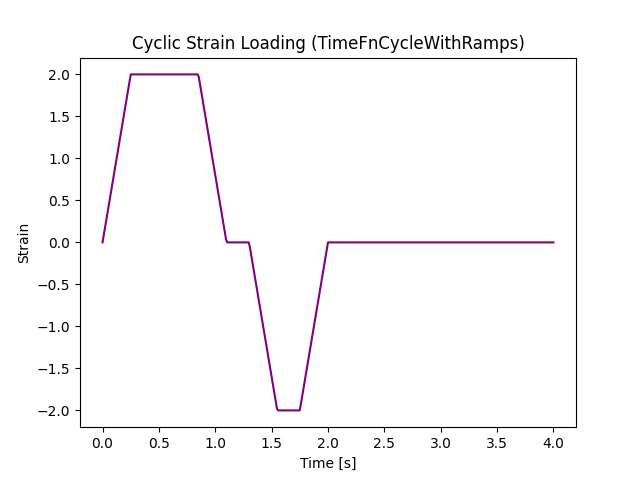

In [29]:
from bmcs_matmod.time_function.time_fn import TimeFnCycleWithRamps

# Define the cyclic time function parameters
cycle_fn = TimeFnCycleWithRamps(urf=0.3)

eps_max = 2
f_time = 2
# Generate time and strain arrays
t_t = np.linspace(0, f_time, 200)
eps_n_t = eps_max * cycle_fn(t_t/f_time)

t_t = np.hstack([t_t[:-1], t_t+t_t[-1]])
eps_n_t = np.hstack([eps_n_t[:-1], np.zeros_like(eps_n_t)])  # Ensure the strain array matches the time array length

# Plot to visualize the cyclic loading
fig, ax = plt.subplots(1, 1)
ax.plot(t_t, eps_n_t, color='purple')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Strain')
ax.set_title('Cyclic Strain Loading (TimeFnCycleWithRamps)')

/tmp/ipykernel_787874/2159304780.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


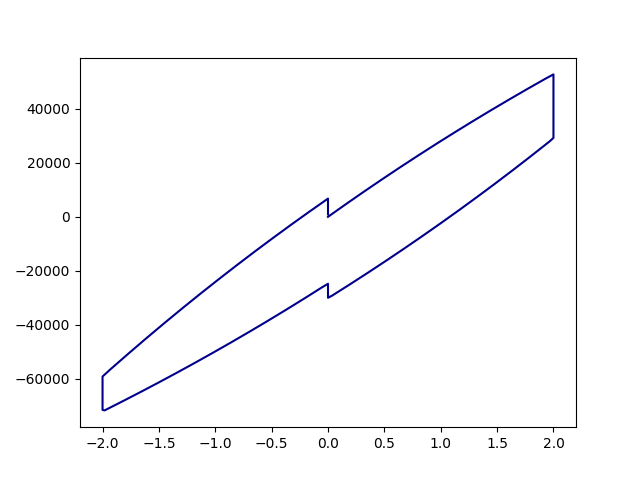

In [30]:
fig, ax = plt.subplots(1, 1)
rd = gsm.get_F_response(eps_n_t, t_t)
ax.plot(rd.eps_t[:, 0], rd.sig_t[:,0,0], color='darkblue')


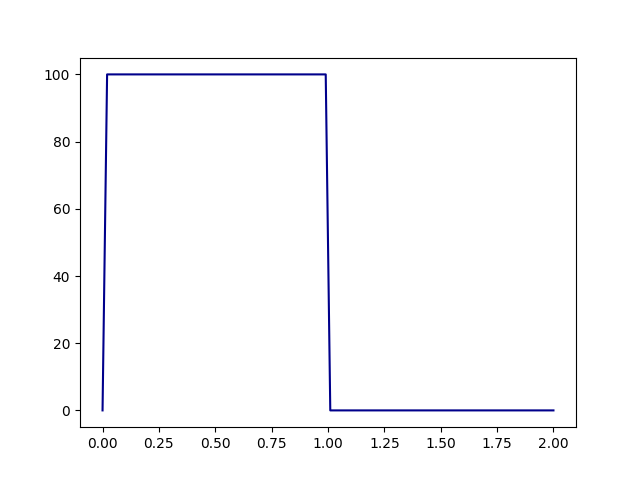

In [22]:
t_, eps_max_, t_1_, t_2_, t_3_ = sp.symbols('t eps_max t_1 t_2 t_3', real=True, positive=True)
sig_t_ = sp.Piecewise(
    (eps_max_ / t_1_ * t_, t_ < t_1_),
    (eps_max_, t_ < t_2_),
    (eps_max_ - eps_max_/(t_3_ - t_2_)*(t_ - t_2_), t_ < t_3_),
    (0, True)
)
get_sig_t = sp.lambdify((t_, eps_max_, t_1_, t_2_, t_3_), sig_t_, 'numpy')
sig_max = 100
f_time = 2
t_t = np.linspace(0, f_time, 100)
sig_n_t = get_sig_t(t_t, sig_max, 0.00025*f_time, 0.5*f_time, 0.500001*f_time)
fig, ax = plt.subplots(1,1)
ax.plot(t_t, sig_n_t, color='darkblue')

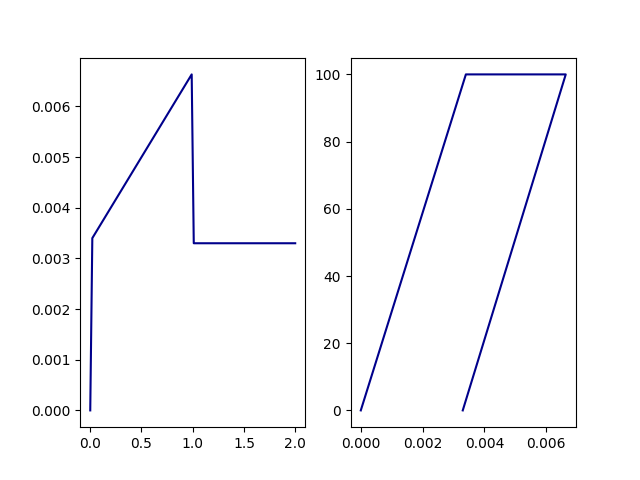

In [13]:
fig, (ax, ax_sig) = plt.subplots(1, 2)
rd = gsm.get_G_response(sig_n_t, t_t)
ax.plot(rd.t_t, rd.eps_t[:, 0], color='darkblue')
ax_sig.plot(rd.eps_t[:, 0], rd.sig_t[:, 0], color='darkblue')


In [31]:
mparams = dict(E = 20, K = 10, S = 10, c = 1, r = 1, eps_0 = 0, f_c = 15, eta_vp=30, eta_ve=10)

n_t = 151
n_I = 1
sig_max = 10
final_time = 10
t_t = np.linspace(0, final_time, n_t)
sig_n_t = np.linspace(0, sig_max, n_t)
gsm.set_params(**mparams)
response = gsm.get_G_response(sig_n_t, t_t)


(100,)


Text(0.5, 0, '$\\varepsilon$')

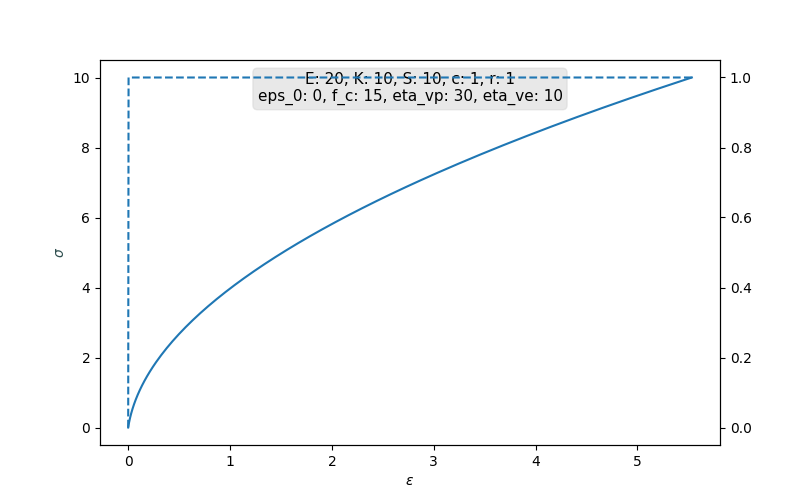

In [32]:
fig, ax_sig = plt.subplots(1, 1, figsize=(8, 5))

ax_iter = ax_sig.twinx()

rd = response
print(iter_t.shape)
eps_t = rd.eps_t[:, 0]
iter_t = rd.iter_t[:, 0]
sig_t = rd.sig_t[:, 0]
ax_sig.plot(eps_t, sig_t)
ax_iter.plot(eps_t, iter_t, ls='dashed')
# Add a box with the material parameters
param_text = ', '.join([f'{key}: {value}' for key, value in mparams.items()])
param_text = '\n'.join([', '.join(param_text.split(', ')[i:i+5]) for i in range(0, len(param_text.split(', ')), 5)])
props = dict(boxstyle='round', facecolor='lightgray', edgecolor='lightgray', alpha=0.5)
ax_sig.text(0.5, 0.97, param_text, transform=ax_sig.transAxes, fontsize=11,
            verticalalignment='top', horizontalalignment='center', bbox=props)
ax_sig.set_ylabel(r'$\sigma$', color='darkslategray')
ax_sig.set_xlabel(r'$\varepsilon$')